# Autoencoder
---
In this project, we will be implementing autoencoder in PyTorch. The mechanism is actually rather simple. In this case, we deal with an input image and we want to encode it to get a low dimensional embedding of the image. After that, we want to decode it again and reconstruct the original image as best as possible.

![title](image.png)

A very cool application for this is video compression when we want to send images over the network from one end to the other end. So instead of sending the whole image, we could simply send over the encoded data and on the other side, where we have the decoder stored and decode the image again. This could save a lot of cost and could be much faster.

---

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
transform = transforms.ToTensor()

# Will convert image range into [-1, 1], and we'll have to use tanh activation in our sequential layer
# transform = transforms.Compose(
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5)),
# )

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                     batch_size=64,
                                     shuffle=True)

In [3]:
data_iter = iter(data_loader)
images, labels = data_iter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## Feed Forward Linear Neural Network

In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super(Autoencoder_Linear, self).__init__()
        self.encoder = nn.Sequential(
            # Initial size <- N, 784
            nn.Linear(784, 128), # Input size <- 784, Output size <- 128
            nn.ReLU(),
            nn.Linear(128, 64),  # Input size <- 128, Output size <- 64
            nn.ReLU(),
            nn.Linear(64, 12),   # Input size <- 64, Output size <- 12
            nn.ReLU(),
            nn.Linear(12, 3)     # Input size <- 12, Output size <- 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),    # Input size <- 3, Output size <- 12
            nn.ReLU(),
            nn.Linear(12, 64),   # Input size <- 12, Output size <- 64
            nn.ReLU(),
            nn.Linear(64, 128),  # Input size <- 64, Output size <- 128
            nn.ReLU(),
            nn.Linear(128, 784), # Input size <- 128, Output size <- 784
            nn.Sigmoid()         # sigmoid activation to convert values into 0-1 range
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note: If values are bewtween -1 and 1, instead of the sigmoid activation function, 
# we'll use the nn.Tanh activation function

In [5]:
learning_rate = 1e-3

model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [6]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 784) 
        
        # Forward pass
        recon = model(img)
        loss = criterion(recon, img)
        
        # Backward pass
        loss.backward()
        
        # Update
        optimizer.step()
        optimizer.zero_grad()
        
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch, img, recon))     

Epoch: 1, Loss: 0.0433
Epoch: 2, Loss: 0.0471
Epoch: 3, Loss: 0.0425
Epoch: 4, Loss: 0.0389
Epoch: 5, Loss: 0.0407
Epoch: 6, Loss: 0.0343
Epoch: 7, Loss: 0.0396
Epoch: 8, Loss: 0.0408
Epoch: 9, Loss: 0.0341
Epoch: 10, Loss: 0.0332


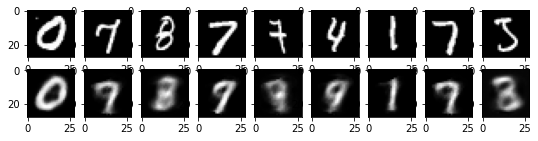

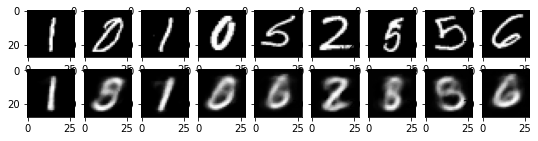

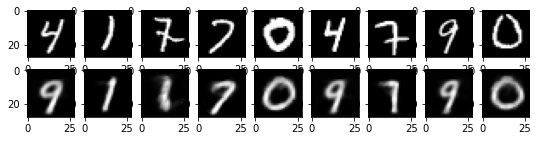

In [7]:
for k in range(0, num_epochs, 4): # plot every fourth epoch
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy() # convert torch.tensor to numpy array
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: # plot only the first nine images
            break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # reshape array back into 28 by 28
        # item: (1, 28, 28)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28)
        # item: (1, 28, 28)
        plt.imshow(item[0])

## Convolutional Neural Network

In [10]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        super(Autoencoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            # Initial size <- N, 1, 28,28
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Output size <- N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output size <- N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                      # Output size <- 64, 1, 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),        # Input size <- 64, Output size <- N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1), # Input size <- 32, Output size <- N, 16, 13->14, 13->14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3,
                               stride=2,
                               padding=1,
                               output_padding=1), # Input size <- 16, Output size <- N, 1, 27->28, 27->28
            nn.Sigmoid()                          # sigmoid activation to convert values into 0-1 range
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
learning_rate = 1e-3

model = Autoencoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [13]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
    
        # Forward pass
        recon = model(img)
        loss = criterion(recon, img)
        
        # Backward pass
        loss.backward()
        
        # Update
        optimizer.step()
        optimizer.zero_grad()
        
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    outputs.append((epoch, img, recon)) 

Epoch: 1, Loss: 0.0073
Epoch: 2, Loss: 0.0058
Epoch: 3, Loss: 0.0040
Epoch: 4, Loss: 0.0036
Epoch: 5, Loss: 0.0031
Epoch: 6, Loss: 0.0026
Epoch: 7, Loss: 0.0030
Epoch: 8, Loss: 0.0030
Epoch: 9, Loss: 0.0026
Epoch: 10, Loss: 0.0027


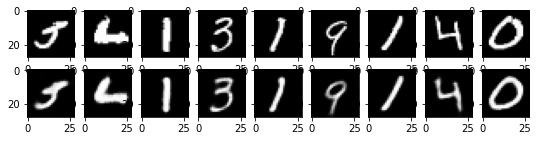

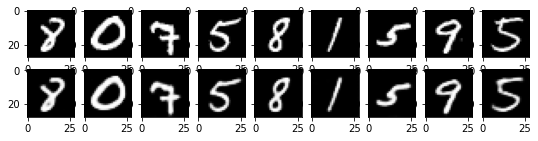

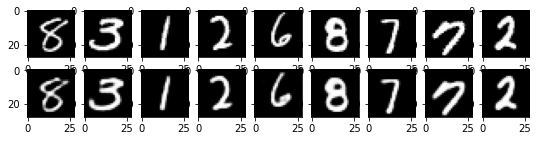

In [14]:
for k in range(0, num_epochs, 4): # plot every fourth epoch
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy() # convert torch.tensor to numpy array
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: # plot only the first nine images
            break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])